# Bayesian Networks 

Project for *Advanced Statistics for Physics Analysis*, University of Padua, A.Y. 2023/24<br>
**Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm** 

**Group members:** Paolo Lapo Cerni, Lorenzo Vigorelli, Arman Singh Bains

***

**Contents**
* [**Functions**](#sec1)
    * [Scoring function(s)](#sec11)
    * [K2 algorithm implementation](#sec12)
    * [K2 pipeline implementation](#sec13)
    * [BNstruct helper functions](#sec14)
    * [SHD functions](#sec15)
* [**Datasets and DAGs**](#sec2)
    * [Ruiz dataset](#sec21)
    * [Child dataset](#sec22)
    * [Asia dataset](#sec23)
    * [Sachs dataset](#sec24)
* [**Comparisons and Analysis**](#sec3)
    * [Number of iterations](#sec31)
    * [Number of parents](#sec32)
* [**BNstruct implementation**](#sec4)
* [**Different methods and conditional probabilities**](#sec5)


In [ ]:
# Packages used
library(dplyr)      |> suppressPackageStartupMessages()
library(readr)      |> suppressPackageStartupMessages()
library(bnlearn)    |> suppressPackageStartupMessages()
library(bnstruct)   |> suppressPackageStartupMessages()
library(Rgraphviz)  |> suppressPackageStartupMessages()
library(foreach)    |> suppressPackageStartupMessages()
library(doParallel) |> suppressPackageStartupMessages()
library(ggplot2)    |> suppressPackageStartupMessages()
library(tidyr)      |> suppressPackageStartupMessages()
library(purrr)      |> suppressPackageStartupMessages()

<a id='sec1'></a>
## Functions

<a id='sec11'></a>
### Scoring function(s)

In [ ]:
## Scoring function for exact results
scoring_function <- function(data, x_i, parents){
  # Find the possible values of the attribute i
  r_i <- data |> distinct(data[[x_i]]) |> nrow()

  if (length(parents) == 0){
    N <- nrow(data)

    num1 <- data |> 
      group_by(data[[x_i]]) |> 
      count() |> 
      mutate(a = factorial(n)) |> 
      ungroup() |> 
      pull(a) |>
      prod()

    # To do consistently with the other case
  } else {
    alpha <- data |> group_by(data[c(x_i, parents)]) |> count()

    N <- alpha |> group_by(alpha[parents]) |> 
      summarise(N = sum(n), .groups = "drop") |> 
      select(N)

    num1 <- alpha |>
      group_by(alpha[parents]) |>
      summarise(alpha = prod(factorial(n)), .groups = "drop") |>
      pull(alpha)
  }

  # Calculate the score
  den <- sapply(N, function(x, r) factorial(x + r - 1), r=r_i)
  num2 <- factorial(r_i - 1)

  return(prod(num2 / den * num1))
}

## Log scoring function to avoid numerical issues
log_scoring_function <- function(data, x_i, parents){
  # Find the possible values of the attribute i
  r_i <- data |> distinct(data[[x_i]]) |> nrow()

  if (length(parents) == 0){
    N <- nrow(data)

    num1 <- data |> 
      group_by(data[[x_i]]) |> 
      count() |> 
      mutate(a = lfactorial(n)) |> 
      ungroup() |> 
      pull(a) |>
      sum()

    # To do consistently with the other case
  } else {
    alpha <- data |> group_by(data[c(x_i, parents)]) |> count()

    N <- alpha |> group_by(alpha[parents]) |> 
      summarise(N = sum(n), .groups = "drop") |> 
      select(N)

    num1 <- alpha |>
      group_by(alpha[parents]) |>
      summarise(alpha = sum(lfactorial(n)), .groups = "drop") |>
      pull(alpha)
  }

  # Calculate the score
  den <- sapply(N, function(x, r) lfactorial(x + r - 1), r=r_i)
  num2 <- lfactorial(r_i - 1)

  return(sum(num1 - den + num2))
}


<a id='sec12'></a>
### K2 algorithm implementation

In [ ]:
K2_algorithm <- function(data, max_parents){
  names <- colnames(data)
  results <- c()

  for (i in 1:ncol(data)){
    x_i <- names[i]
    parents <- c()
    p_old <- log_scoring_function(data, x_i, parents)
    proceed <- TRUE
    
    while (proceed){
      # Check if the maximum number of parents has been reached
      if (length(parents) >= max_parents){
        break
      }

      # Compute the predecessors
      predecessors <- setdiff(names[0:(i-1)], parents)
      if (length(predecessors) == 0){
        break
      }

      # Try adding a new parent
      scores <- sapply(predecessors, function(z) log_scoring_function(data, x_i, c(z, parents)))
      p_new <- max(scores)
      
      # If the score increases, add the parent
      if (p_new > p_old){
        p_old <- p_new
        parents <- c(parents, names[which.max(scores)])
      } else {
        proceed <- FALSE
      }
    } # end while
    
    results[[x_i]] <- parents
  } # end for

  return(list(names=names, parents_list=results))
}


<a id='sec13'></a>
### K2 pipeline implementation

In [ ]:
# Convert the parent-child relationships to a DAG
get_dag <- function(names, parents_list){
  dag <- empty.graph(names)

  # Add arcs based on the parent-child relationships
  for (child in names) {
    parents <- parents_list[[child]]
    if (length(parents) > 0) {
      for (parent in parents) {
        dag <- set.arc(dag, from = parent, to = child)
      }
    }
  }
  return(dag)
}


K2_to_dag <- function(data, max_parents){
  # Run the K2 algorithm
  results <- K2_algorithm(data, max_parents)
  names <- results$names
  parents_list <- results$parents_list

  # Convert the parent-child relationships to a DAG
  dag <- get_dag(names, parents_list)

  # Get the score of the DAG
  score <- score(dag, data)

  return(list(dag=dag, score=score))
}


K2_pipeline <- function(data, max_parents, max_iter, mode="local", n_cores=-1, return_history=FALSE){
  # Check if the mode is valid
  if (mode != "local" && mode != "parallel") {
    stop("Invalid mode. Please use 'local' or 'parallel'.")
  }

  # Return history only works in local mode
  if (return_history && mode == "parallel") {
    stop("Return history only works in local mode.")
  }
  
  # If the data does not have column names, assign them
  if (is.null(colnames(data))) {
    colnames(data) <- paste0("X", 1:ncol(data))
  }

  # Randomly shuffle data rows
  data <- data[sample(nrow(data)), ]

  # Try different random orders of the columns
  if (mode == "local") {
    history <- array(data = NA, dim = c(max_iter))

    # Initialize the best score and DAG
    score_best <- -Inf
    dag_best <- NULL

    # Try different random orders of the columns
    for (i in 1:max_iter){
      if (i > 1) {
        data <- data |> select(sample(colnames(data)))
      }
      result <- K2_to_dag(data, max_parents)
      score <- result$score

      # Update the best DAG
      if (score > score_best){
        score_best <- score
        dag_best <- result$dag
      }

      # Save the history
      history[i] <- score_best

    } 

    if (return_history) {
      return(list(dag=dag_best, score=score_best, history=history))
    }
    return(list(dag=dag_best, score=score_best))

  } else if (mode == "parallel") {
      # Setup parallel processing
      if (n_cores == -1) {
        n_cores <- detectCores()
      }
      cl <- makeCluster(n_cores)
      registerDoParallel(cl)

      # Try different random orders of the columns in parallel
      results <- mclapply(1:max_iter, function(i) {
        data_sampled <- data |> select(sample(colnames(data)))
        result <- K2_to_dag(data_sampled, max_parents)
        return(result)
      }, mc.cores = n_cores)

      # Initialize best score and DAG
      score_best <- -Inf
      dag_best <- NULL

      # Find the best result
      for (res in results) {
        if (res$score > score_best) {
          score_best <- res$score
          dag_best <- res$dag
        }
      }

      return(list(dag=dag_best, score=score_best))
    }

  return(NULL)
}

<a id='sec14'></a>
### BNstruct helper functions

In [ ]:
learning <- function (data, maxParent, algo = "k2", percentage = 1, plot = F) {
    # Check if the percentage is within the valid range
    if (percentage < 0 || percentage > 1) {
        stop("Percentage must be between 0 and 1.")
    }

    # Subset the data based on the given percentage
    # Shuffle the rows of the data randomly
    data <- data[sample(nrow(data)), ]
    num_rows <- nrow(data)
    data <- data[1:as.integer(percentage * num_rows), ]

    # Determine the starting value for the dataset
    minValue <- min(data, na.rm = TRUE)
    startsFrom <- ifelse(minValue == 0, 0, 1)

    # Calculate the number of unique values for each column in the data
    sizes <- sapply(data, function(x) length(unique(x)))
    sizes <- as.numeric(sizes)

    # Create a BNDataset object with the given data
    dataset <- BNDataset(data = data,
                         discreteness = rep(TRUE, ncol(data)),
                         variables = colnames(data), 
                         starts.from = startsFrom, 
                         node.sizes = sizes)
                    
    # Learn the network structure using the specified algorithm
    dag <- learn.network(algo = algo, x = dataset, max.parents = maxParent)

    # Create an empty graph and set its adjacency matrix
    net = empty.graph(names(data))
    amat(net) <- dag(dag)

    # Convert data columns to factors
    for (i in 1:length(names(data))) {
        name = names(data)[i]
        data[, name] = as.factor(as.character(data[, name]))
    }

    # Calculate the score of the network
    score <- score(net, data = data)

    # Plot the DAG if the plot parameter is TRUE
    if (plot) {
        plot(dag)
    }
        
    # Return the DAG and its score as a list
    return(list(dag = net, score = score))
}


<a id='sec15'></a>
### SHD functions

In [ ]:
# Function to compute the Structural Hamming Distance (SHD) between two networks
computeShdSingle <- function(theor, empir, plot=FALSE) {
  
  # Convert the theoretical and empirical networks to adjacency matrices
  DAG1 <- amat(theor)
  DAG2 <- amat(empir)
  
  # Compute the Structural Hamming Distance between the two adjacency matrices
  shd <- shd(DAG1, DAG2)
  
  # If plot is TRUE, visualize the comparison between the two networks
  if (plot) {
    graphviz.compare(theor, empir, shape="rectangle")
  }
  
  # Return the computed SHD
  return(shd)
}


# Function to compute the Structural Hamming Distance (SHD) between a theoretical model and a list of empirical models
computeShd <- function(theor, empirList, plot=FALSE) {
  # Convert the theoretical model to an adjacency matrix
  DAG1 <- amat(theor)
  
  # Compute the SHD between the theoretical model and each empirical model in the list
  shd_values <- sapply(empirList, function(empir) shd(DAG1, amat(empir)))
  
  # If plot is TRUE, visualize the comparison between the models
  if (plot) {
    # Create a list of graphs to visualize, including the theoretical model and the empirical models
    plot_list <- c(list(theor), empirList)
    
    # Number of empirical models
    num_empirical <- length(empirList)
    
    # Main titles for the graphs
    titles <- c("THEORETICAL MODEL", paste("EMPIRICAL MODEL", seq_len(num_empirical)))
    # Subtitles for the graphs, including the SHD values
    subtitles <- c(paste("SHD =", "0"), paste("SHD =", shd_values))
    
    # Visualize the comparative graphs using graphviz.compare
    do.call(graphviz.compare, c(list(plot_list[[1]]), plot_list[-1], 
                                list(shape = "rectangle", 
                                     main = titles, 
                                     sub = subtitles,
                                     diff.args = list(tp.lwd = 2, tp.col = "green", fn.col = "orange"))))
  }
  
  # Return the computed SHD values
  return(shd_values)
}

<a id='sec2'></a>
## Datasets and DAGs

<a id='sec21'></a>
### Ruiz dataset

In [4]:
records <- c(1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0)
ruiz_example  <- data.frame(matrix(records, 10,3, byrow=TRUE))

ruiz_example

X1,X2,X3
<dbl>,<dbl>,<dbl>
1,0,0
1,1,1
0,0,1
1,1,1
0,0,0
0,1,1
1,1,1
0,0,0
1,1,1


In [5]:
print(scoring_function(ruiz_example, "X3", c()))
print(log_scoring_function(ruiz_example, "X3", c()))

[1] 0.0004329004
[1] -7.745003


In [6]:
res <- K2_pipeline(ruiz_example, max_parents=3, max_iter=1)
print(paste("Score: ", res$score))

[1] "Score:  -23.3137121136653"


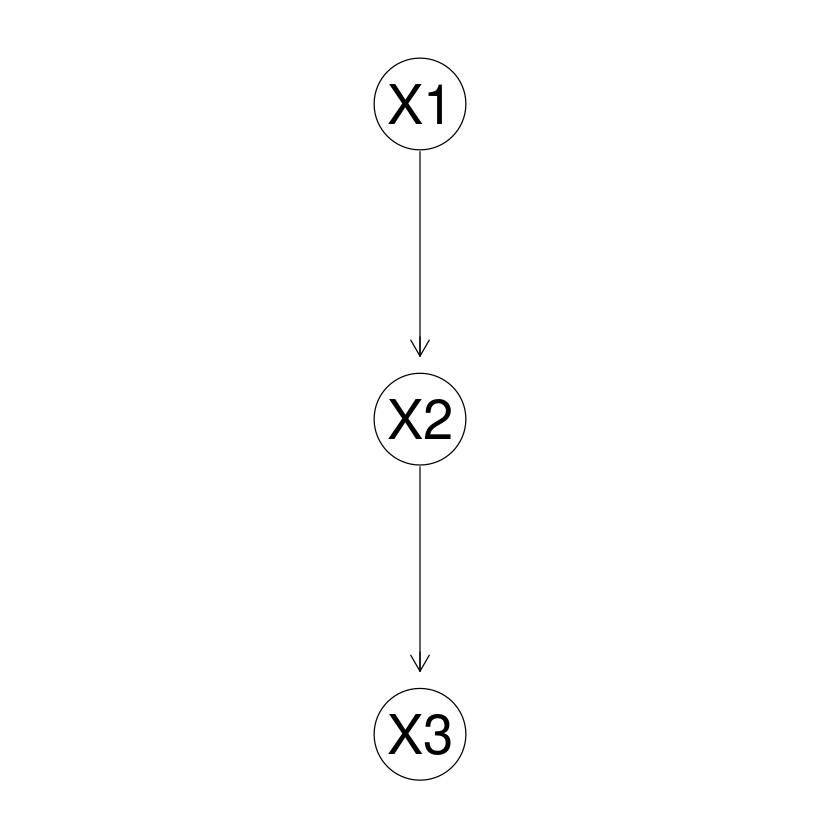

In [7]:
dag <- res$dag
graphviz.plot(dag, shape="circle")

<a id='sec22'></a>
### Child dataset

In [8]:
# Load the data
child_df <- child() |> # S4 object
  impute() |> # Impute the dataset to remove missing values
  imputed.data() |> # Extract the imputed dataset
  as.data.frame() # Convert to a data frame

# Set the column names
colnames(child_df) <- child()@variables
print(colnames(child_df))

head(child_df)

bnstruct :: performing imputation ...



bnstruct :: imputation finished.



 [1] "BirthAsphyxia"  "Disease"        "Age"            "LVH"           
 [5] "DuctFlow"       "CardiacMixing"  "LungParench"    "LungFlow"      
 [9] "Sick"           "HypDistrib"     "HypoxiaInO2"    "CO2"           
[13] "ChestXray"      "Grunting"       "LVHReport"      "LowerBodyO2"   
[17] "RUQO2"          "CO2Report"      "XrayReport"     "GruntingReport"


,BirthAsphyxia,Disease,Age,LVH,DuctFlow,CardiacMixing,LungParench,LungFlow,Sick,HypDistrib,HypoxiaInO2,CO2,ChestXray,Grunting,LVHReport,LowerBodyO2,RUQO2,CO2Report,XrayReport,GruntingReport
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,3,3,2,1,3,1,1,2,1,1,1,1,2,2,2,3,2,1,2
2,2,4,2,1,1,2,1,2,2,1,2,1,2,2,1,2,2,1,2,2
3,2,3,1,2,1,3,1,2,2,1,2,2,2,2,2,1,2,1,2,2
4,2,4,1,1,1,3,1,1,2,1,3,1,1,2,1,3,1,1,1,2
5,2,2,1,2,2,4,1,1,1,1,3,1,1,2,2,1,1,1,2,2
6,2,2,1,2,1,4,1,3,2,1,3,1,3,2,2,2,1,1,3,2


In [9]:
#res <- K2_to_dag(child_df, max_parents=3)
res <- K2_pipeline(child_df, max_parents=3, max_iter=3)
print(paste("Score: ", res$score))

[1] "Score:  -79690.8041605567"


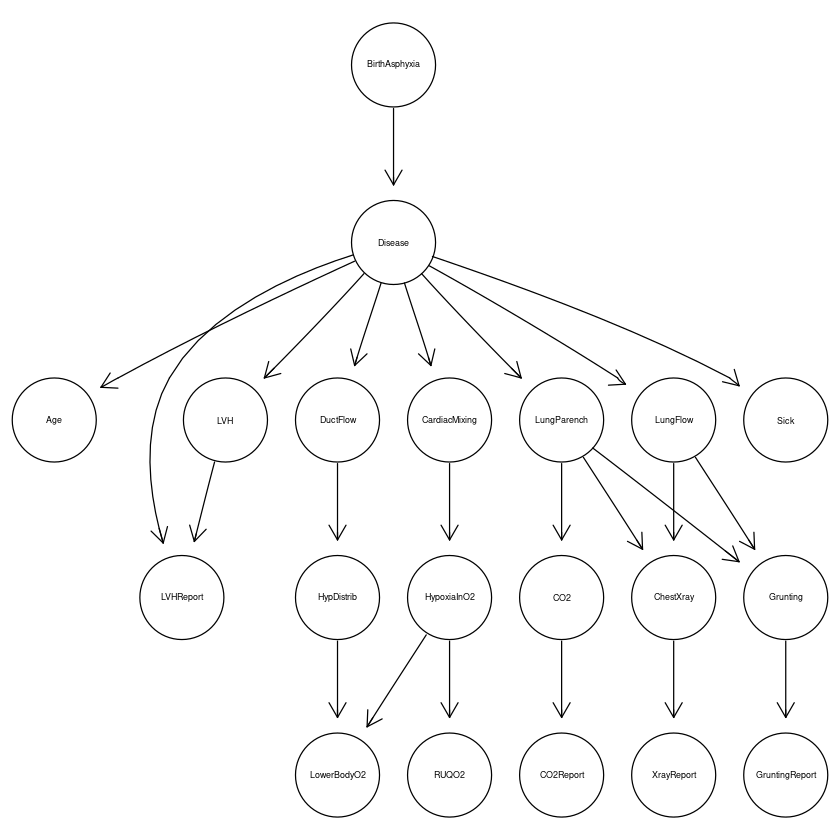

In [10]:
dag <- res$dag
graphviz.plot(dag, shape="circle")

<a id='sec23'></a>
### Asia dataset

In [11]:
asia_df <- asia() |> # S4 object
  impute() |> # Impute the dataset to remove missing values
  imputed.data() |> # Extract the imputed dataset
  as.data.frame() # Convert to a data frame

# Set the column names
colnames(asia_df) <- asia()@variables
print(colnames(asia_df))

head(asia_df)

bnstruct :: performing imputation ...



bnstruct :: imputation finished.



[1] "Asia"         "Tubercolosys" "Smoke"        "LungCancer"   "Bronchitis"  
[6] "Either"       "X-ray"        "Dyspnea"     


,Asia,Tubercolosys,Smoke,LungCancer,Bronchitis,Either,X-ray,Dyspnea
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,2,1,1,1,2,1,2
2,2,1,1,1,1,1,2,1
3,1,1,2,1,1,1,2,1
4,2,1,2,1,1,1,2,1
5,2,1,2,1,1,1,1,2
6,2,1,2,1,1,1,2,2


In [12]:
#res <- K2_to_dag(asia_df, max_parents=3)
res <- K2_pipeline(asia_df, max_parents=3, max_iter=3)
print(paste("Score: ", res$score))

[1] "Score:  10743.2294954573"


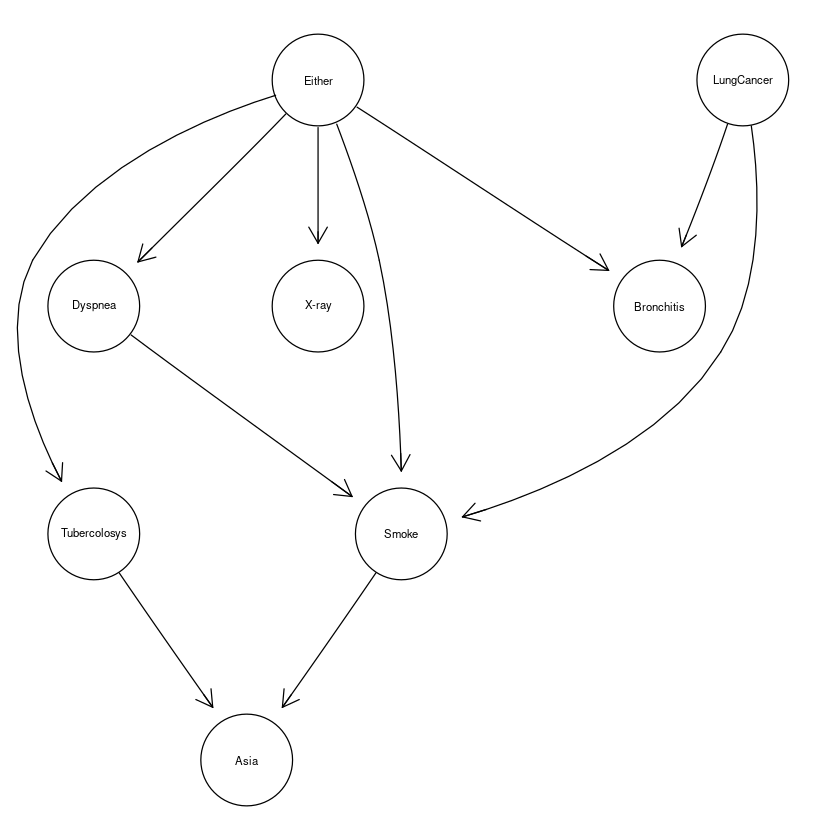

In [13]:
dag <- res$dag
graphviz.plot(dag, shape="circle")

<a id='sec24'></a>
### Sachs dataset

In [14]:
sachs_df <- read_csv('https://www.ccd.pitt.edu/wiki/images/SACHS10k.csv', show_col_types = FALSE)
head(sachs_df)

Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,Plcg,Raf
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1,1,1,2,2,3,1,1
1,2,1,1,2,1,2,2,2,1,1
1,1,3,1,3,2,2,1,1,3,3
1,2,1,1,1,1,3,3,1,1,2
1,2,1,1,1,1,3,2,2,2,1
1,2,2,2,1,1,1,2,2,1,2


In [15]:
#res <- K2_to_dag(sachs_df, max_parents=3)
res <- K2_pipeline(sachs_df, max_parents=3, max_iter=3)
print(paste("Score: ", res$score))

[1] "Score:  -95738.9938439234"


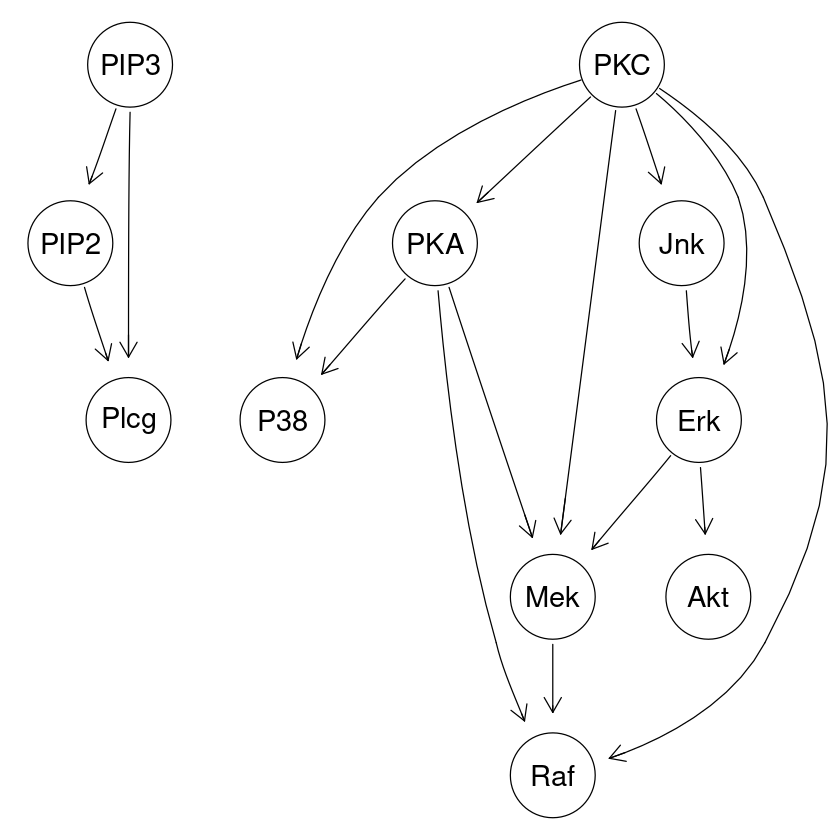

In [16]:
dag <- res$dag
graphviz.plot(dag, shape="circle")

<a id='sec3'></a>
## Comparisons and Analysis

In [17]:
datasets <- list(
  asia = asia_df,
  child = child_df,
  sachs = sachs_df
)

<a id='sec31'></a>
### Number of iterations

In [18]:
# Helper function to get the rescaled history from a dataset
get_rescaled_history <- function(data, iters){
  res <- K2_pipeline(data, max_parents=3, max_iter=iters, mode="local", return_history=TRUE)
  hist <- res$history
  if (min(hist) == max(hist)){
    hist <- array(data = 1, dim = c(iters))
  } else {
    hist <- (hist - min(hist)) / (max(hist) - min(hist))
  }
  return(hist)
}

In [17]:
n_realizations <- 5

# Create the long-format data frame
results <- map2_df(
  names(datasets), datasets,
  ~ {
    # Loop over each realization
    map_df(1:n_realizations, function(realization_id) {
      # Generate the time series scores
      hist <- get_rescaled_history(.y, 15)
      
      # Create a data frame for the current realization
      data.frame(
        dataset_id = .x,               # The name of the current dataset
        realization_id = realization_id, # Current realization index
        time_point = seq_along(hist), # Iterations
        score = hist            # The scores for each time point
      )
    })
  }
)

# Save the data frame to an RDS file
saveRDS(results, file = "./temp_data/convergenceK2.rds")

In [15]:
# Load the data frame from the RDS file
results <- readRDS("./temp_data/convergenceK2.rds")

In [16]:
# Summarize the results
summary_stats <- results |>
  group_by(dataset_id, time_point) |>
  summarize(
    mean_score = mean(score),
    sd_score = sd(score),
    .groups = 'drop'
  )

The following plot shows the convergence of the algorithm with the number of iterations. Note that on the *y-axis* there is the (MinMax) rescaled score to compare the different datasets

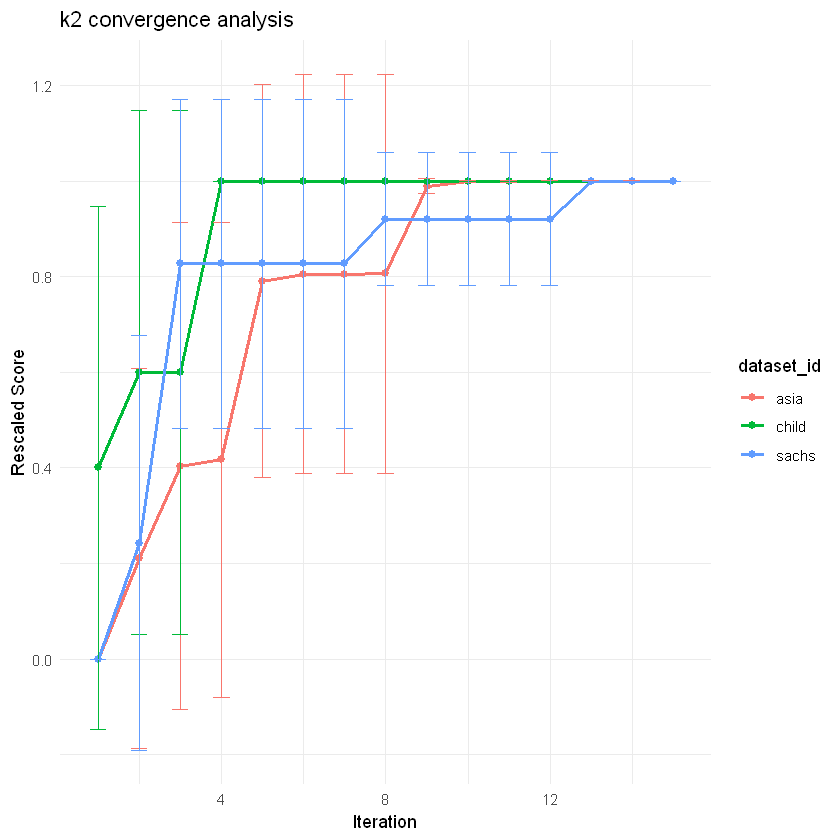

In [17]:
# Plot the analysis about the convergence
ggplot(summary_stats, aes(x = time_point, y = mean_score, color = dataset_id)) +
  geom_line(linewidth = 1) +  # Line plot
  geom_point(size = 2) +  # Points
  geom_errorbar(aes(ymin = mean_score - sd_score, ymax = mean_score + sd_score), 
                width = 0.4) +  # Error bars
  labs(title = "k2 convergence analysis",
       x = "Iteration",
       y = "Rescaled Score") +
  theme_minimal()


<a id='sec32'></a>
### Number of parents

In [ ]:
n_realizations <- 5

# Create the long-format data frame
results <- map2_df(
  names(datasets), datasets,
  ~ {
    # Loop over each realization
    map_df(1:n_realizations, function(realization_id) {

      map_df(1:5, function(max_parents) {
        # Generate the scores
        res <- K2_pipeline(.y, max_parents=max_parents, 
                           max_iter=10, mode="local")
        score <- res$score
        
        # Create a data frame for the current realization
        data.frame(
          dataset_id = .x,               # The name of the current dataset
          realization_id = realization_id, # Current realization index
          score = score,            # The scores for each time point
          max_parents = max_parents # The maximum number of parents
        )
      })

    })
  }
)

# Save the data frame to an RDS file
saveRDS(results, file = "./temp_data/parentsK2.rds")

In [18]:
# Load the data frame from the RDS file
results <- readRDS("./temp_data/parentsK2.rds")

In [19]:
# Summarize the results
summary_stats <- results |>
  group_by(dataset_id, max_parents) |>
  summarize(
    mean_score = mean(score),
    sd_score = sd(score),
    .groups = 'drop'
  )

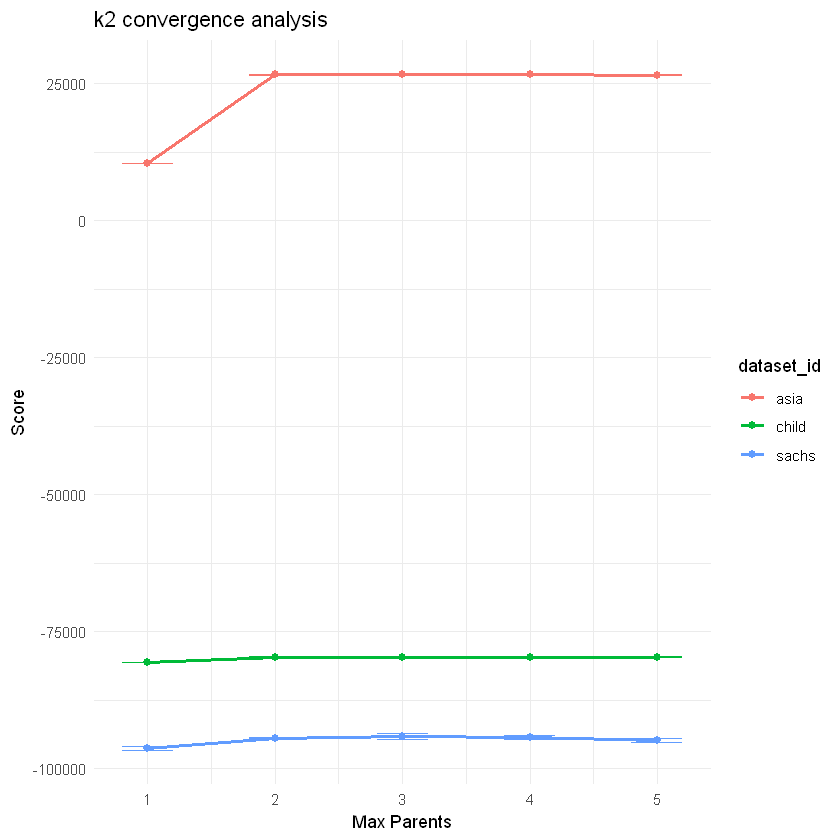

In [20]:
# Plot the analysis about the convergence
ggplot(summary_stats, aes(x = max_parents, y = mean_score, color = dataset_id)) +
  geom_line(linewidth = 1) +  # Line plot
  geom_point(size = 2) +  # Points
  geom_errorbar(aes(ymin = mean_score - sd_score, ymax = mean_score + sd_score), 
                width = 0.4) +  # Error bars
  labs(title = "k2 convergence analysis",
       x = "Max Parents",
       y = "Score") +
  theme_minimal()


<a id='sec4'></a>
## BNstruct implementation

We show the results with using bnstruct to compute the best dag using as example the Child Data set

In [ ]:
# Define a vector of algorithms to be used for learning the DAGs
algorithms <- c("hc", "sm", "mmpc", "mmhc", "sem")

# Initialize empty lists to store the DAGs and their scores
dag_listChild <- list()
score_listChild <- list()

# Loop through each algorithm in the algorithms vector
for (algo in algorithms) {
  # Learn the DAG using the specified algorithm and parameters
  dagChild <- learning(child_df, maxParent=5, algo = algo, percentage = 1, plot = F)
  
  # Store the learned DAG in the dag_listAsia list, using the algorithm name as the key
  dag_listChild[[algo]] <- dagChild$dag
  
  # Store the score of the learned DAG in the score_listAsia list, using the algorithm name as the key
  score_listChild[[algo]] <- dagChild$score
}

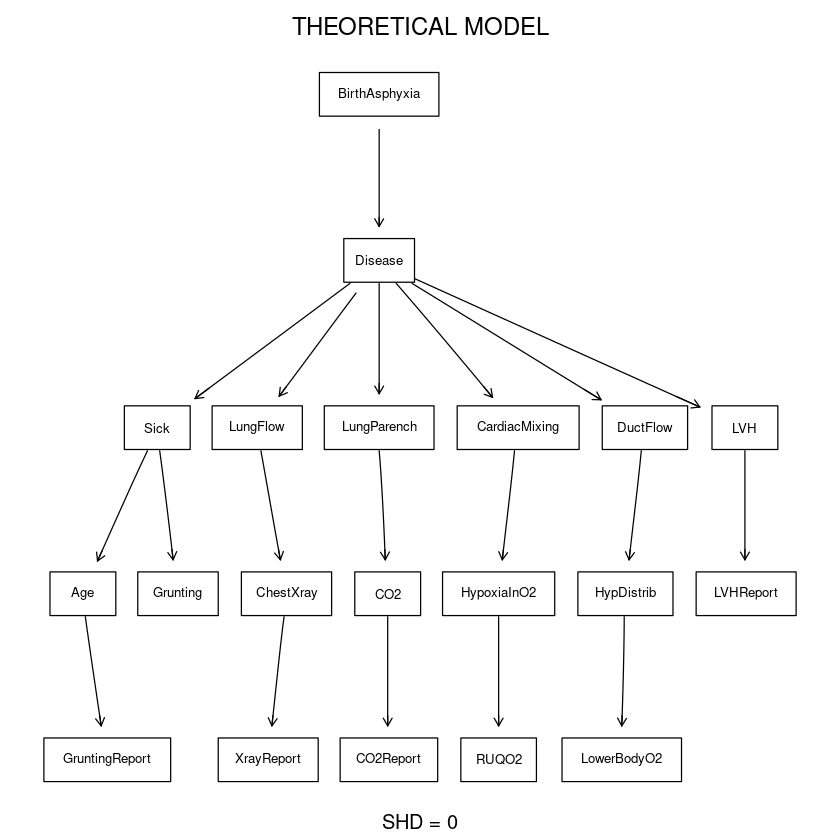

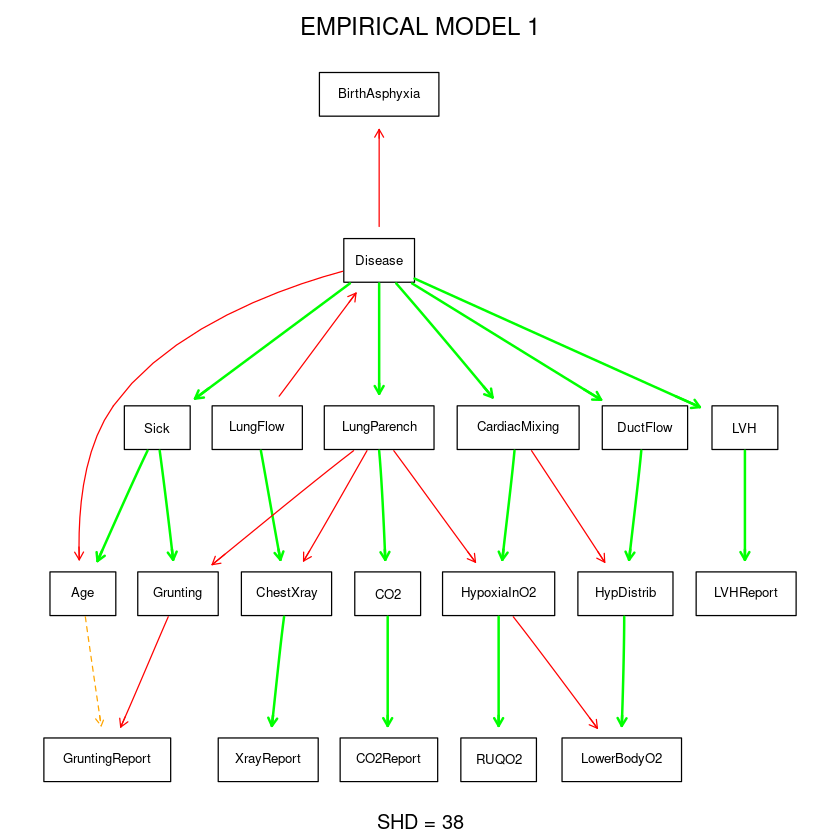

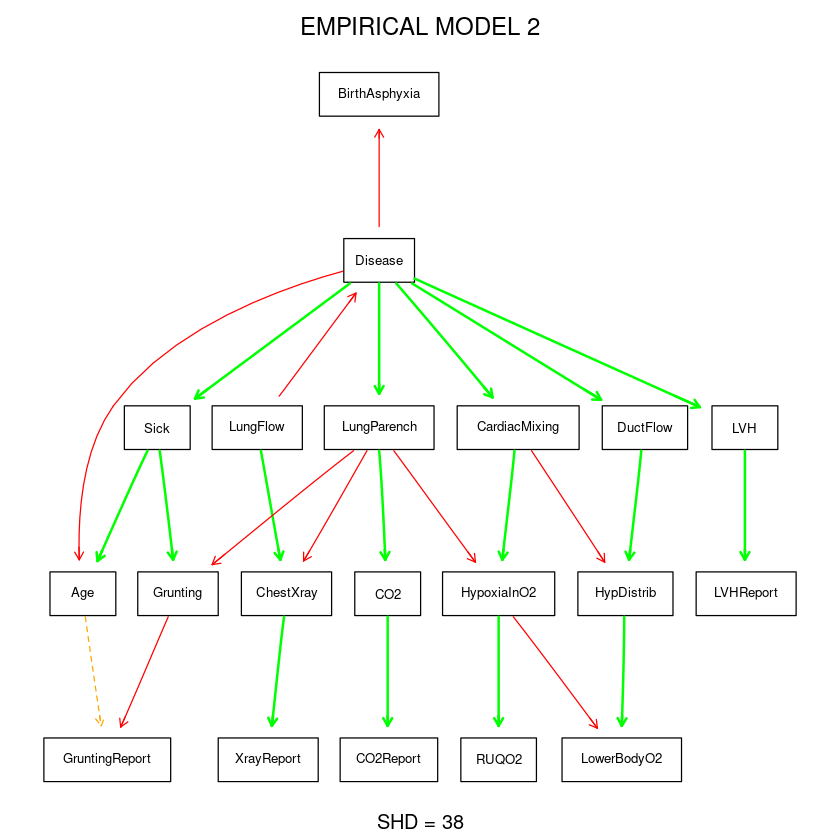

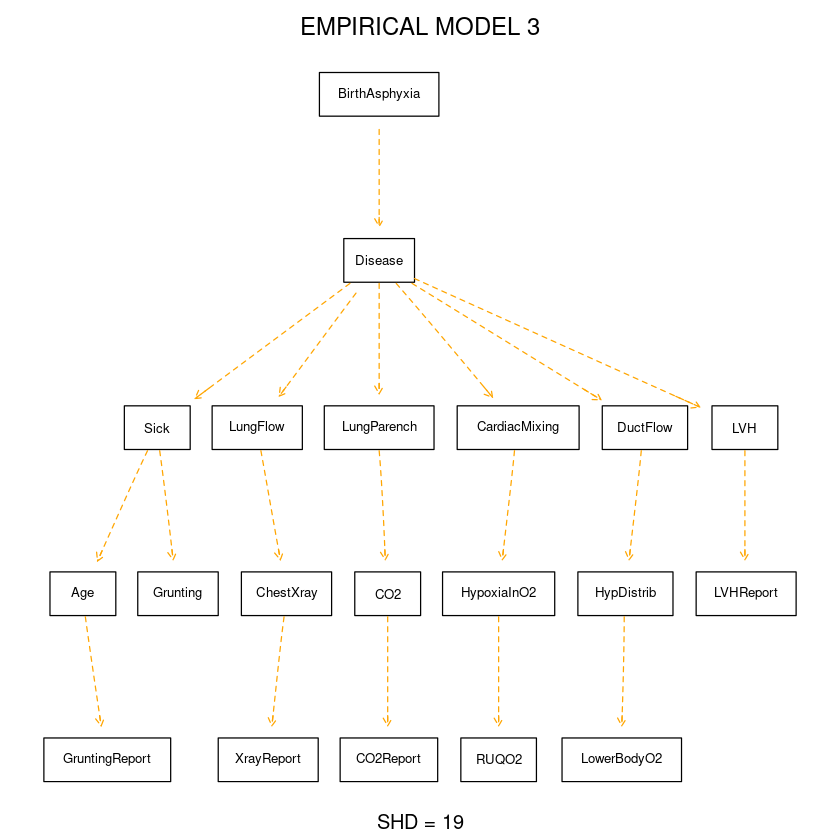

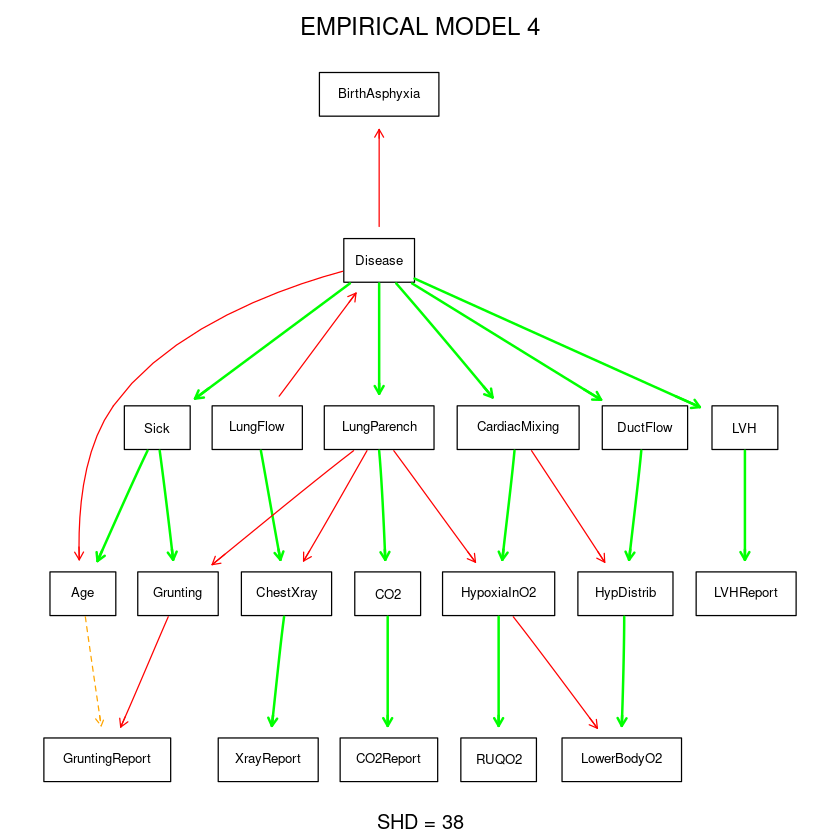

hc   sm mmpc mmhc  sem 
  38   38   19   38   38

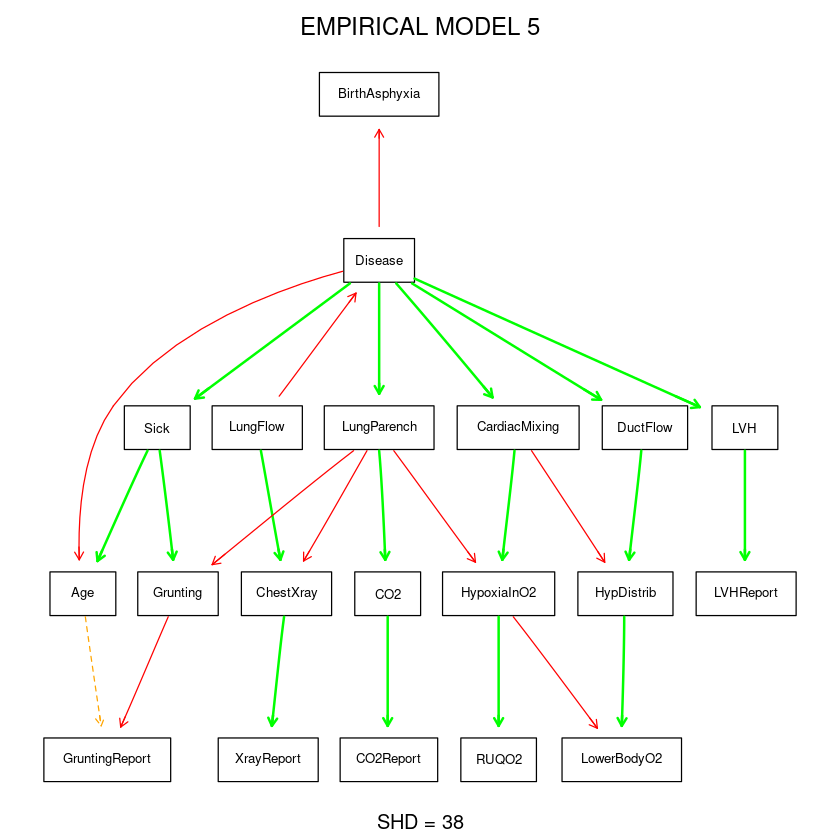

In [25]:
# Define the theoretical DAG using the model2network function
theorDAG <- model2network("[BirthAsphyxia][Disease|BirthAsphyxia][Sick|Disease][DuctFlow|Disease][CardiacMixing|Disease][LungParench|Disease][LungFlow|Disease][LVH|Disease][Age|Sick][Grunting|Sick][HypDistrib|DuctFlow][HypoxiaInO2|CardiacMixing][CO2|LungParench][ChestXray|LungFlow][LVHReport|LVH][GruntingReport|Age][LowerBodyO2|HypDistrib][RUQO2|HypoxiaInO2][CO2Report|CO2][XrayReport|ChestXray]")

# Assign the list of learned DAGs to a variable
listChild <- dag_listChild

# Compute the Structural Hamming Distance (SHD) between the theoretical DAG and the list of learned DAGs
# Also, plot the comparison between the theoretical DAG and each learned DAG
computeShd(theorDAG, dag_listChild, plot = T)
theorDAG_child <- theorDAG

These plots show the the DAG, the colors indicate the differences between the theoretical one from Bnlearn and the empirical one obtain with the algorithm.
The different plots show different algorithms. It is also showed the shd, an index of how many differences are between two DAG

<a id='sec5'></a>
## Different methods and conditional probabilities

In [26]:
res_child <- K2_pipeline(child_df, max_parents = 3, max_iter = 3)
dag.child.k2 <- res_child$dag

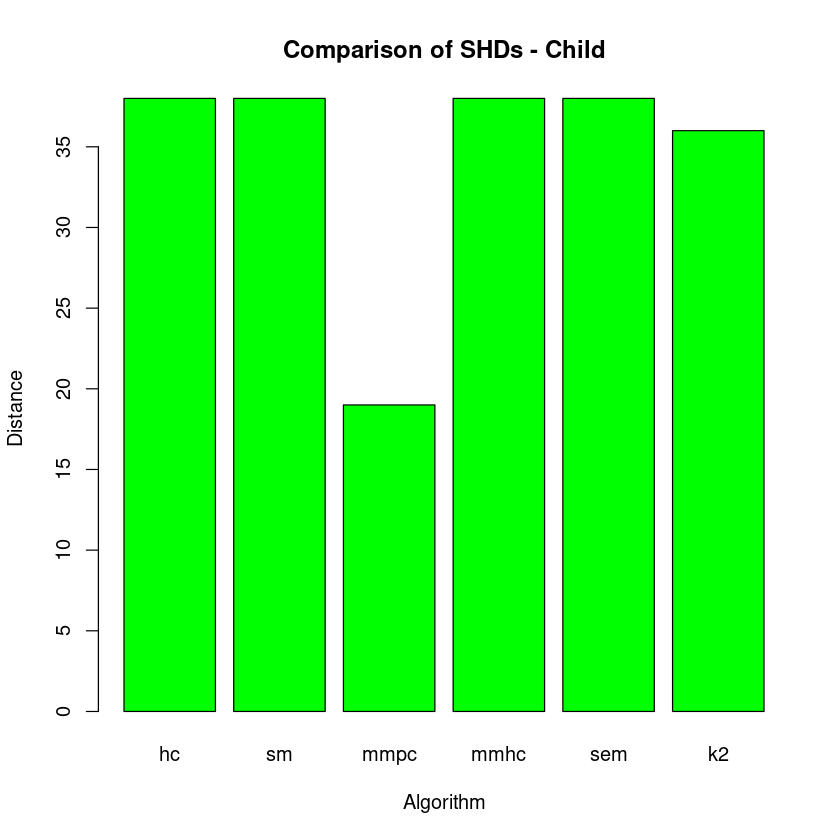

In [27]:
# shd plot
theorDAG <- theorDAG_child
computed <- lapply(dag_listChild, function(dag) computeShdSingle(theor = theorDAG, empir = dag))
computed$k2 <- computeShdSingle(theor = theorDAG, empir = dag.child.k2)
# Create a bar chart of the computed scores
barplot(unlist(computed), names.arg = names(computed), xlab = "Algorithm", ylab = "Distance", main = "Comparison of SHDs - Child", col = "green")

In [30]:
df <- data.frame(apply(child_df, c(1, 2), as.character), stringsAsFactors = TRUE)

bn_bayes$th <- bn.fit(theorDAG, df, method = "bayes", iss = 10)
bn_bayes$k2 <- bn.fit(theorDAG, df, method = "bayes", iss = 10)
bn_bayes <- lapply(listChild, function(child) bn.fit(child, df, method = "bayes", iss = 10))

Loading required namespace: lattice



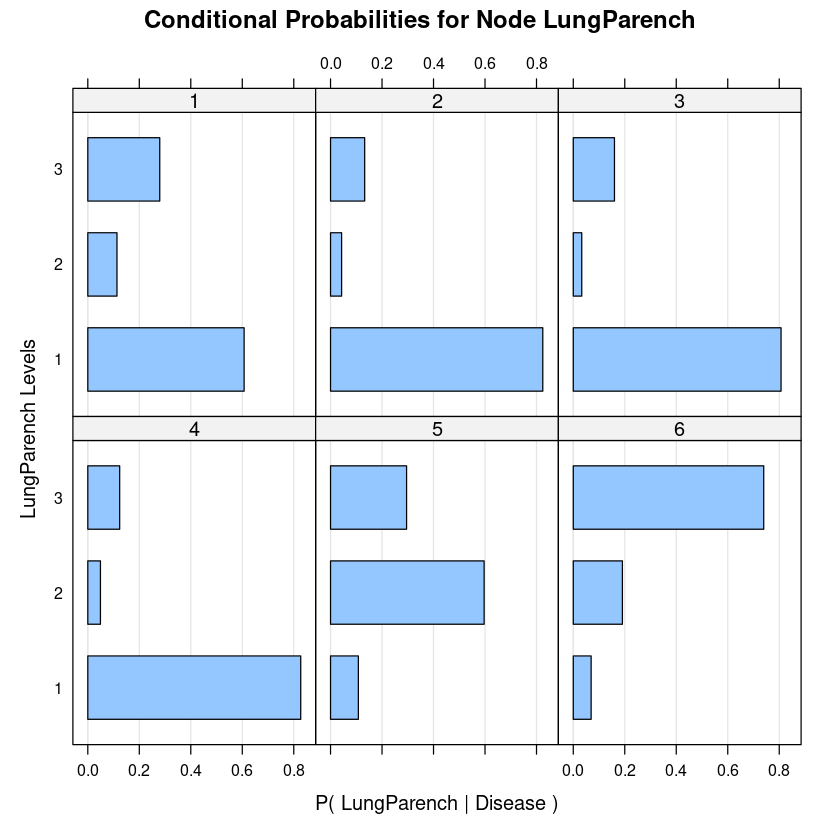

In [31]:
plot_xlab <- function(bn, node, ylab = '') {
    conditionals <- parents(bn, node)
    parent_string <- paste(conditionals, collapse = ", ")
    label <- paste("P(", node, "|", parent_string, ")")
    bn.fit.barchart(bn[[node]], xlab = label, ylab = ylab)
}
plot_xlab(bn_bayes$mmhc, 'LungParench', 'LungParench Levels')